In [1]:
import ccxt
import numpy as np
import pandas as pd 
import time
from datetime import datetime, timezone

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf

86400

In [26]:
binance = ccxt.binance()

def ExportData(crypto, timeframe, num_data=None, since_days=None, start_date=None, end_date=None ):
    sec_per_day = 60*60*24
    if since_days is not None:

        since = int((time.time() - since_days*sec_per_day)*1000)
        end = None

    elif start_date and end_date:

        since = int(datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp() * 1000)
        end = int(datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp() * 1000)

    else:
        raise ValueError("You must provide either 'since_day' or both 'start_date' and 'end_date' ")
    
    all_data = []


    while True:
        ohlcv = binance.fetch_ohlcv(crypto, timeframe, since=since, limit=num_data or 1000)
        if not ohlcv:
            break

        all_data.extend(ohlcv)

        since = ohlcv[-1][0] + 1

        if  num_data and len(all_data) >= num_data:
            break

        # if end and since >= end:
        #     break

    df = pd.DataFrame(all_data, columns= ['timestamp', 'open', 'high', 'low', 'close', 'volume'] ) 
    df['timestamp'] = pd.to_datetime(df["timestamp"], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Bogota')

    df_1 = df[(df["timestamp"] >= start_date) & (df['timestamp'] <= end_date) ]
    df_2 = df[df['timestamp'] > end_date]

    return df_1, df_2




In [33]:
start_hour = "17:00:00"
finish_hour = "18:00:00"

start_d = f'2025-02-24 {start_hour}'
finish_d = f'2025-02-24 {finish_hour}'

df_train, df_test = ExportData(
    crypto="BNB/USDT",
    timeframe="1s",
    start_date=start_d,
    end_date=finish_d
)



In [48]:

scaler = MinMaxScaler(feature_range=(0,1))
def create_sequences(data,time_steps=15):
    data = data.copy()
    
    data['close'] =scaler.fit_transform(data[['close']])

    X,y = [], []

    for i in range(len(data['close'] ) - time_steps):
        X.append(data['close'].iloc[i:i+time_steps])
        y.append(data['close'].iloc[i+time_steps])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    split = int(0.8*len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, y_train, X_test, y_test


time_steps = 30
X_train, y_train, X_test, y_test = create_sequences(df_train[['timestamp', 'close']], time_steps=time_steps)

def build_model():
    
    model = tf.keras.Sequential([
            tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
            tf.keras.layers.LSTM(50, return_sequences=False),
            tf.keras.layers.Dense(25, activation="relu"),
            tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=32, verbose=1)
    return history, model

def validation_set(data):
    data_val = scaler.fit_transform(data)
    data_val = np.array(data_val)
    return data_val.reshape(data_val.shape[0], data_val.shape[1], 1)

hist, model = build_model()


Epoch 1/5
90/90 [==============================] - 4s 19ms/step - loss: 0.0127 - val_loss: 0.0026
Epoch 2/5
90/90 [==============================] - 1s 10ms/step - loss: 8.0995e-04 - val_loss: 9.2019e-04
Epoch 3/5
90/90 [==============================] - 1s 10ms/step - loss: 7.2259e-04 - val_loss: 7.4471e-04
Epoch 4/5
90/90 [==============================] - 1s 10ms/step - loss: 6.6266e-04 - val_loss: 6.9474e-04
Epoch 5/5
90/90 [==============================] - 1s 10ms/step - loss: 6.3051e-04 - val_loss: 7.6521e-04


13/13 [==============================] - 0s 2ms/step


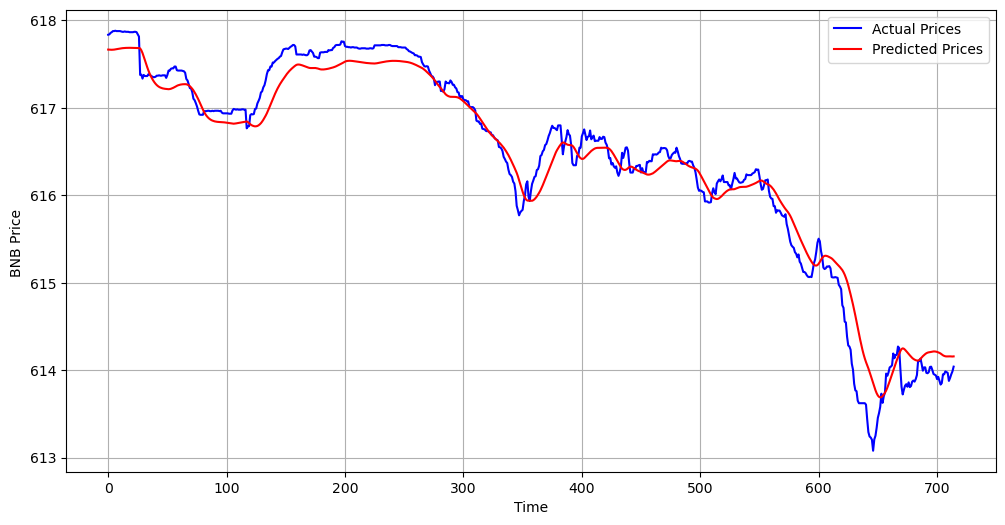

In [ ]:
validation = validation_set(data=df_test[['close']])

predicted = model.predict(X_test)
predicted_val = model.predict(validation)


predicted_price = scaler.inverse_transform(predicted.reshape(-1,1) )
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))




plt.figure(figsize=(12,6))
plt.plot( actual_prices, label= 'Actual Prices', color='blue')
plt.plot( predicted_price, label='Predicted Prices', color='red')


plt.xlabel('Time')
plt.ylabel('BNB Price ')
plt.legend()
plt.grid()
plt.show()


In [ ]:

predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))

test_day_day['timestamp'] = pd.to_datetime(test_day_day['timestamp'])
test_day_day['hour']=test_day_day['timestamp'].dt.strftime('%H:%M')

x_axis_hours = test_day_day['hour'][-len(actual_prices):]



plt.figure(figsize=(12,6))
plt.plot( actual_prices, label= 'Actual Prices', color='blue')
plt.plot( predicted_prices, label='Predicted Prices', color='red')


plt.xlabel('Time')
plt.ylabel('BNB Price ')
plt.legend()
plt.grid()
plt.show()